In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import nltk
from itertools import chain
from collections import Counter
import matplotlib 

In [2]:
# download english stopwords and punctuation marks:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1. Defining helper functions

### 1.1 pre-processing functions and pipeline

In [3]:
## pre-processing functions for single text
def lower(sentence):
    s = str(sentence)
    return s.lower()

def remove_subject(sentence):
    sentence = sentence[1:]
    return sentence

def tokenize(sentence): 
    return nltk.word_tokenize(sentence)

def remove_stop_words(sentence):
    stop_words = nltk.corpus.stopwords.words('english')
    return tuple(item for item in sentence if item not in stop_words and item.isalnum())


def stem(sentence):
    stemmer = nltk.stem.SnowballStemmer('english')
    words = [stemmer.stem(word) for word in sentence]
    return words

def preprocess_sentence(sentence, func1=lower, func2=remove_subject, func3=tokenize, func4=remove_stop_words, func5=stem): #full pre-prcessing pipeline
    return func5(func4(func3(func2(func1(sentence)))))


## pre-processing functions for list of texts
def lower_list(sentence_list):
    sentence_list=sentence_list.str.lower()
    return sentence_list

def tokenize_list(sentence_list): 
    sentence_list = list(map(nltk.word_tokenize, sentence_list))
    return sentence_list

def remove_subject_list(sentence_list):
    sentence_list = list(map(lambda x: x[1:], sentence_list))
    return sentence_list


def remove_stop_words_list(sentence_list):
    stop_words = nltk.corpus.stopwords.words('english')
    sentence_list = list(map(lambda x: tuple(item for item in x if item not in stop_words and item.isalpha()), sentence_list))
    return sentence_list

def stem_list(sentence_list):   # stemming & lemmatizing
    stemmer = nltk.stem.SnowballStemmer('english')
    #stemmer = nltk.stem.PorterStemmer()
    #stemmer = nltk.stem.LancasterStemmer()
    
    all_words = []
    for sentence in sentence_list:
        words_list = []
        for word in sentence:
            words_list.append(stemmer.stem(word))
            
        all_words.append(tuple(words_list))
        
    return all_words


def preprocess_sentence_list(sentence, func1=lower_list, func2=tokenize_list, 
                             func3=remove_subject_list, func4=remove_stop_words_list, func5=stem_list): #full pre-processing pipeline
    return func4(func3(func2(func1(sentence))))

### 1.2 Naive Bayes functions

In [5]:
# NB with Laplacian smoothing

def classes_probability(data):
    P_spam = (data.value_counts()[1]+1)/(sum(data.value_counts()) + len(data.value_counts()))
    P_ham = (data.value_counts()[0]+1)/(sum(data.value_counts()) + len(data.value_counts()))
    return (P_spam, P_ham)

def words_probability_per_class(train):
    # make a dictionary of unique words and the probability of each word
    freqs = nltk.FreqDist(word for sentence in train['text'] for word in sentence) #frequency of each word
    num_unique_words = freqs.N()
    num_total_words = sum(len(x) for x in train['text'])
    words_dict= dict(freqs.items())
    #words_dict = {k: v/total_words for k, v in words_dict.items()} # probability of each word p(word)
    
    train_spam = train[train['spam']==1] # filter spam samples
    train_spam.reset_index(inplace=True) 
    train_spam.drop(columns=['index'], inplace=True)

    train_ham = train[train['spam']==0] # filter ham samples
    train_ham.reset_index(inplace=True) 
    train_ham.drop(columns=['index'], inplace=True)
    
    
    
    ## dictionary of P(w|C) for word in each class
    # frequency of each word in each class
    spam_freq = nltk.FreqDist(word for i in range(len(train_spam["text"])) for word in train_spam["text"][i]) 
    ham_freq = nltk.FreqDist(word for i in range(len(train_ham["text"])) for word in train_ham["text"][i]) 

    spam_words_dict=dict(spam_freq.items())
    ham_words_dict=dict(ham_freq.items())
    
    num_total_spam_words = sum(len(x) for x in train_spam['text'])
    num_total_ham_words = sum(len(x) for x in train_ham['text'])
    

    # laplacian-smoothed P(W|C)
    spam_words_dict = {k: (v+1)/(num_total_spam_words+num_unique_words) for k, v in spam_words_dict.items()}
    spam_words_dict['num_total_spam_words'] = num_total_spam_words
    ham_words_dict = {k: (v+1)/(num_total_ham_words+num_unique_words) for k, v in ham_words_dict.items()}
    ham_words_dict['num_total_ham_words'] = num_total_ham_words

    
    
    return (spam_words_dict, ham_words_dict, num_unique_words)


def determine_spam(words, num_unique_words, spam_words_dict, ham_words_dict, P_spam, P_ham):
    if(type(words)==list or type(words)==pd.core.series.Series):
        return determine_spam_dict(words, num_unique_words, spam_words_dict, ham_words_dict, P_spam, P_ham) 
    else:
        return determine_spam_single(words, num_unique_words, spam_words_dict, ham_words_dict, P_spam, P_ham)
    
def determine_spam_dict(sentence_dict, num_unique_words, spam_words_dict, ham_words_dict, P_spam, P_ham):
    results = []
    for sentence in sentence_dict:
        # get P(w|spam) for each word, for words in the training set
        lis_spam_probs = [spam_words_dict[word] if word in spam_words_dict 
                          else 1/(spam_words_dict['num_total_spam_words']+num_unique_words) for word in sentence] 
        # get P(w|spam) for each word, for words not in the taining set
        lis_ham_probs = [ham_words_dict[word] if word in ham_words_dict 
                         else 1/(ham_words_dict['num_total_ham_words']+num_unique_words) for word in sentence] 
        
        p1 = P_spam * np.prod(lis_spam_probs)
        p2 = P_ham * np.prod(lis_ham_probs)
        
        if (p1 > p2):
            results.append(1)
                
        else:
            results.append(0)
        
    return results


def determine_spam_single(words, words_dict, spam_words_dict, ham_words_dict, P_spam, P_ham):
    lis_spam_probs = [spam_words_dict[word] if word in spam_words_dict 
                          else 1/(spam_words_dict['num_total_spam_words']+num_unique_words) for word in words] 
    lis_ham_probs = [ham_words_dict[word] if word in ham_words_dict 
                         else 1/(ham_words_dict['num_total_ham_words']+num_unique_words) for word in sentence]
    p1 = P_spam * np.prod(lis_spam_probs)
    p2 = P_ham * np.prod(lis_ham_probs)

    if (p1 > p2):
        print('spam')
    else:
        print('ham')
    


# 2. Workin on development data

## 2.1 Data split and pre-processing

In [6]:
all_data = pd.read_csv("/workspace/new_src/dataset/emails.csv")

In [7]:
all_data.head(5)

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [8]:
# split data to train and test sets
train, test = train_test_split(all_data, test_size=0.3, random_state=42, shuffle=True)
train.to_csv("/workspace/new_src/dataset/train.csv", index=False)
test.to_csv("/workspace/new_src/dataset/test.csv", index=False)

In [9]:
train_df = train.copy()

In [10]:
preprocessed_tokens = preprocess_sentence_list(train_df['text'])

In [11]:
train_df["text"] = preprocessed_tokens
train_df.head()

,text,spam
3931,"(volatility, curves, linked, reuters, hi, tany...",0
4056,"(organizational, announcement, fyi, forwarded,...",0
4546,"(lng, meeting, hello, lng, meeting, held, morn...",0
2471,"(fwd, optical, network, engineering, enron, re...",0
2481,"(argentina, modelling, michael, p, thursday, v...",0


## 2.2 Calculate needed probabilities

In [12]:
# P(C)
(P_spam, P_ham) = classes_probability(train['spam'])
print(P_spam, P_ham)

0.23136374968835702 0.768636250311643


In [ ]:
# P(W|C)
spam_words_dict, ham_words_dict, num_unique_words = words_probability_per_class(train_df)

## 2.3 Evaluate on development set

In [15]:
list_precitions = determine_spam(train_df['text'], num_unique_words, spam_words_dict, ham_words_dict, 
                                 P_spam, P_ham)

In [18]:
results = train_df['spam'] == list_precitions # get list where TP+TN is True and FP+FN is False

In [19]:
accuracy1 = results.value_counts()[1]/(results.value_counts()[0]+results.value_counts()[1])
accuracy2 = metrics.accuracy_score(train_df['spam'], list_precitions)
print(accuracy1, accuracy2)

0.8822649039660764 0.8822649039660764


In [21]:
results2 = train['spam'] & list_precitions
results2.value_counts()
precision1 = results2.value_counts()[1]/(np.sum(list_precitions))
precision2 = metrics.precision_score(train_df['spam'], list_precitions)
print(precision1, precision2)

1.0 1.0


In [25]:
recall2 = metrics.recall_score(train['spam'], list_precitions)
print(recall2)

0.49083063646170444


In [29]:
f1 = 2*(precision1*recall2)/(precision1+recall2)
f2 = metrics.f1_score(train['spam'],list_precitions)
print(f1, f2)

0.658465991316932 0.658465991316932


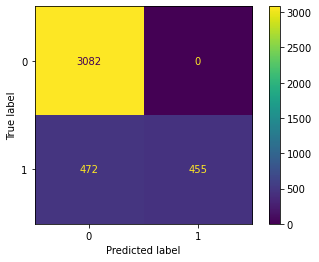

In [30]:
conf_max = metrics.confusion_matrix(train['spam'], list_precitions,labels=[0,1])
metrics.ConfusionMatrixDisplay(conf_max, display_labels=[0, 1]).plot()

# 3. Testing

### Batch emails filtering (test set)

In [37]:
test = pd.read_csv("/workspace/new_src/dataset/test.csv")
test.head()

,text,spam
0,Subject: re : energy derivatives conference - ...,0
1,"Subject: financial maths course , part 2 vinc...",0
2,Subject: re : bullet points please respond to...,0
3,"Subject: re : enron default swaps darrell , ...",0
4,"Subject: re : power question steve , elena c...",0


In [38]:
preprocessed_tokens = preprocess_sentence_list(test['text'])

In [39]:
test["text"] = preprocessed_tokens

In [40]:
list_precitions = determine_spam(test['text'], num_unique_words, spam_words_dict, ham_words_dict, 
                                 P_spam, P_ham)

# 4. Perfromance Metrics

### 4.1 Accuracy metric: (TP+TN)/(TP+FP+TN+FN)

In [41]:
results = test['spam'] == list_precitions # get list where TP+TN is True and FP+FN is False
results.value_counts()

True     1453
False     266
Name: spam, dtype: int64

In [42]:
accuracy = results.value_counts()[1]/(results.value_counts()[0]+results.value_counts()[1])
accuracy

0.8452588714368819

In [43]:
acc = metrics.accuracy_score(test['spam'], list_precitions)
acc

0.8452588714368819

### 4.2 Precision metric: TP/(TP+FP)

In [44]:
results2 = test['spam'] & list_precitions
results2.value_counts()

False    1544
True      175
Name: spam, dtype: int64

In [45]:
precision = results2.value_counts()[1]/(np.sum(list_precitions))
precision

1.0

In [46]:
prec = metrics.precision_score(test['spam'], list_precitions)
prec

1.0

### 4.3 Recall metric: TP/(TP+FN)

In [47]:
FN = [1 for i in range(len(test['spam'])) if test['spam'][i] == 1 and list_precitions[i] == 0]
np.sum(FN)

266

In [48]:
recall = results2.value_counts()[1]/(results2.value_counts()[1]+np.sum(FN))
recall

0.3968253968253968

In [49]:
rec = metrics.recall_score(test['spam'], list_precitions)
rec

0.3968253968253968

### 4.4 F1 metric: 2*(Precission*Recall)/(Precession+Recall)

In [50]:
f1 = 2*(precision*recall)/(precision+recall)
f1

0.5681818181818182

In [51]:
f1_sk = metrics.f1_score(test['spam'],list_precitions)
f1_sk

0.5681818181818182